In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 기본전처리

In [ ]:
df = pd.read_csv("dd_sfc_td.csv", encoding = "utf-8-sig")

In [ ]:
def preprocess(df, dfname = "", to_csv = False):
    if type(df) == str: #df대신 df 경로 및 파일명 입력시
        df = pd.read_csv(df, encoding = "utf-8-sig")
    if df.columns[0] == "Unnamed: 0":
        df = df.loc[:, 1:]
    df.columns = [x.replace("a.", "") for x in df.columns] #colnames
    df["yyyymmdd"] = df[df.columns[0]].apply(lambda x: int(x.split(" ")[0].replace("-", "")))
    df = df.loc[:, df.isnull().mean() != 1]
    if to_csv == True:
        df.to_csv(dfname + ".csv", index = False, encoding = "utf-8-sig")
    return df

def daily(df, back, dfname = "", to_csv = False):
    if type(df) == str: #df대신 df 경로 및 파일명 입력시
        df = pd.read_csv(df, encoding = "utf-8-sig")
    final = pd.DataFrame()
    for s in df["stn_id"].unique():
        print(s, " is processing")
        ss = pd.merge(back, df[df["stn_id"] == s], how = "left", on = "yyyymmdd")
        ss["stn_id"] = s
        final = pd.concat([final, ss], axis = 0)
    if to_csv == True:
        final.to_csv(dfname + ".csv", encoding = "utf-8-sig", index = False)
    return final

def after_daily(df, area, dfname = "", to_csv = False):
    if type(df) == str:
        df = pd.read_csv(df)
    if "isnull" in df.columns:
        df.drop("isnull", axis = 1, inplace = True)
    df.drop(df.columns[["Unnamed" in x for x in df.columns]], axis = 1, inplace = True)
    tm = df.columns[["tm" in x for x in df.columns]][0]
    df[tm] = df["yyyymmdd"].apply(lambda x: str(x)[:4] + "-" + str(x)[4:6] + "-" + str(x)[6:])
    idx = df.columns[[x not in ["yyyymmdd", tm, "stn_id"] for x in df.columns]]
    print(idx)
    df = pd.merge(df, area, how = "left", on = "stn_id")
    for i in df[df["name"].isnull()]["stn_id"].unique():
        #step 1 :과반수 이상의 열에서 해당 관측소 결측 50% 이상
        #if (np.round(df.query("stn_id == @i")[idx].isnull().mean(), 1) > 0.5).mean() > 0.5:
        #    df = df.query("stn_id != @i").reset_index(drop = True)
        #step 2 : 필요한 기간의 데이터가 없을 경우(특히 타겟시점!)
        un = df.query("stn_id == @i").dropna(subset = idx)[tm].apply(lambda x: x[:4]).unique()
        if "2011" in un and len(un) < 6:
            df = df.query("stn_id != @i").reset_index(drop = True)
        elif len(un) < 4 or "2016" not in un:
            df = df.query("stn_id != @i").reset_index(drop = True)
    if to_csv == True:
        df.to_csv(dfname + ".csv", encoding = "utf-8-sig", index = False)
    return idx, df

In [ ]:
df = preprocess(df)
print(df.isnull().sum())
df

In [ ]:
back_path = "/Users/seong-yeseul/Downloads/pm10_agg_mac.csv" #경로는 알아서,,
back = pd.DataFrame(pd.read_csv(back_path, encoding = "utf-8-sig")["yyyymmdd"].unique(), columns = ["yyyymmdd"])
df = daily(df, back)
print(df.isnull().sum())
df

In [ ]:
df.to_csv("daily_sfc_td.csv", encoding = "utf-8-sig", index = False)

# Mapping

In [2]:
area = pd.read_csv("mapping_0712.csv")
df = pd.read_csv("daily_sfc_td.csv", encoding = "utf-8-sig")
display(df.head())
print(df.isnull().mean()) #tma결측인 이유 : yyyymmdd기준 합병했기 때문에 해당 데이터가 원래 없으면 나머지 싹 결측치로 들어감.

,yyyymmdd,tma,stn_id,avg_td,max_td,max_td_hrmt,min_td,min_td_hrmt
0,20110101,2011-01-01,90,-8.9,-3.6,1100.0,-15.6,100.0
1,20110102,2011-01-02,90,-9.0,-3.7,1600.0,-14.8,1500.0
2,20110103,2011-01-03,90,-3.6,-1.8,900.0,-5.6,0.0
3,20110104,2011-01-04,90,-12.0,-6.9,100.0,-15.2,1200.0
4,20110105,2011-01-05,90,-13.2,-10.6,500.0,-15.1,2100.0


yyyymmdd       0.000000
tma            0.059007
stn_id         0.000000
avg_td         0.060099
max_td         0.059625
max_td_hrmt    0.059625
min_td         0.059625
min_td_hrmt    0.059625
dtype: float64


In [3]:
def after_daily(df, area, dfname = "", to_csv = False):
    if type(df) == str:
        df = pd.read_csv(df)
    if "isnull" in df.columns:
        df.drop("isnull", axis = 1, inplace = True)
    df.drop(df.columns[["Unnamed" in x for x in df.columns]], axis = 1, inplace = True)
    tm = df.columns[["tm" in x for x in df.columns]][0]
    df[tm] = df["yyyymmdd"].apply(lambda x: str(x)[:4] + "-" + str(x)[4:6] + "-" + str(x)[6:])
    idx = df.columns[[x not in ["yyyymmdd", tm, "stn_id"] for x in df.columns]]
    print(idx)
    df = pd.merge(df, area, how = "left", on = "stn_id")
    for i in df[df["name"].isnull()]["stn_id"].unique():
        #step 1 :과반수 이상의 열에서 해당 관측소 결측 50% 이상
        if (np.round(df.query("stn_id == @i")[idx].isnull().mean(), 1) > 0.5).mean() > 0.5:
            df = df.query("stn_id != @i").reset_index(drop = True)
        #step 2 : 필요한 기간의 데이터가 없을 경우(특히 타겟시점!)
        un = df.query("stn_id == @i").dropna(subset = idx)[tm].apply(lambda x: x[:4]).unique()
        if "2011" in un and len(un) < 6:
            df = df.query("stn_id != @i").reset_index(drop = True)
        elif len(un) < 4 or "2016" not in un:
            df = df.query("stn_id != @i").reset_index(drop = True)
    if to_csv == True:
        df.to_csv(dfname + ".csv", encoding = "utf-8-sig", index = False)
    return idx, df

In [4]:
idx, df = after_daily(df, area)

Index(['avg_td', 'max_td', 'max_td_hrmt', 'min_td', 'min_td_hrmt'], dtype='object')


In [5]:
print(df.isnull().sum())
display(df.info())

yyyymmdd           0
tma                0
stn_id             0
avg_td         10859
max_td         10756
max_td_hrmt    10756
min_td         10756
min_td_hrmt    10756
name               0
address            0
lat                0
long               0
add                0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214816 entries, 0 to 214815
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   yyyymmdd     214816 non-null  int64  
 1   tma          214816 non-null  object 
 2   stn_id       214816 non-null  int64  
 3   avg_td       203957 non-null  float64
 4   max_td       204060 non-null  float64
 5   max_td_hrmt  204060 non-null  float64
 6   min_td       204060 non-null  float64
 7   min_td_hrmt  204060 non-null  float64
 8   name         214816 non-null  object 
 9   address      214816 non-null  object 
 10  lat          214816 non-null  float64
 11  long         214816 non-null  float64
 

None

In [7]:
for col in idx:
    if "hrmt" not in col:
        print(col)
        ii = df[df[col] < -80].index
        if len(ii) > 0:
            display(df.loc[ii, :])
            #df.loc[ii, col] = np.nan
        ii = df[df[col] > 60].index
        if len(ii) > 0:
            display(df.loc[ii, :])
            #df.loc[ii, col] = np.nan
#최저 -80, 최고 60 벗어나는 범위 없음!

avg_td
max_td
min_td


In [8]:
df.to_csv("null_sfc_td.csv", encoding = "utf-8-sig", index = False)

In [9]:
area3 = df[["stn_id", "name", "lat", "long", "add"]].drop_duplicates().reset_index(drop = True)
for col in idx:
    for s in df[df[col].isnull()]["stn_id"].unique():
        latlon = df.query("stn_id == @s")[["lat", "long"]].drop_duplicates().values[0]
        x = (np.cos(latlon[0]) * 6400 * 2 * np.pi / 360) * np.abs(latlon[1] - area3[["long"]])
        y = 111 * np.abs(latlon[0] - area3["lat"])
        distance = np.sqrt((x**2).squeeze() + y**2).sort_values().head(6)
        dd = pd.concat([area3.iloc[distance.index.to_list(), :], pd.DataFrame(distance, columns = ["dist"])], axis = 1)
        #display(dd)
        tg = df[df["stn_id"] == s]
        ss = dd["stn_id"]
        ii = tg[tg[col].isnull()].index
        ymd = df.loc[ii, "yyyymmdd"]
        #display(df.loc[ii, :])
        df.loc[ii, col] = np.nanmean(df.query("stn_id in @ss and stn_id != @s").pivot(index = "yyyymmdd", columns = "stn_id", values = col).query("yyyymmdd in @ymd"), axis = 1)
        #print(np.nanmean(df.query("stn_id in @ss and stn_id != @s").pivot(index = "yyyymmdd", columns = "stn_id", values = col).query("yyyymmdd in @ymd"), axis = 1))
df.isnull().sum()

yyyymmdd       0
tma            0
stn_id         0
avg_td         0
max_td         0
max_td_hrmt    0
min_td         0
min_td_hrmt    0
name           0
address        0
lat            0
long           0
add            0
dtype: int64

In [10]:
df.to_csv("final_sfc_td.csv", encoding = "utf-8-sig", index = False)

# 결측치 대체

## 단순평균

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv("null_sfc_td.csv", encoding = "utf-8-sig")
display(df.head())
print(df.isnull().sum())

,yyyymmdd,tma,stn_id,avg_td,max_td,max_td_hrmt,min_td,min_td_hrmt,name,address,lat,long,add
0,20110101,2011-01-01,90,-8.9,-3.6,1100.0,-15.6,100.0,속초,강원도 고성군 토성면 봉포리,38.250875,128.564715,강원
1,20110102,2011-01-02,90,-9.0,-3.7,1600.0,-14.8,1500.0,속초,강원도 고성군 토성면 봉포리,38.250875,128.564715,강원
2,20110103,2011-01-03,90,-3.6,-1.8,900.0,-5.6,0.0,속초,강원도 고성군 토성면 봉포리,38.250875,128.564715,강원
3,20110104,2011-01-04,90,-12.0,-6.9,100.0,-15.2,1200.0,속초,강원도 고성군 토성면 봉포리,38.250875,128.564715,강원
4,20110105,2011-01-05,90,-13.2,-10.6,500.0,-15.1,2100.0,속초,강원도 고성군 토성면 봉포리,38.250875,128.564715,강원


yyyymmdd           0
tma                0
stn_id             0
avg_td         10859
max_td         10756
max_td_hrmt    10756
min_td         10756
min_td_hrmt    10756
name               0
address            0
lat                0
long               0
add                0
dtype: int64


In [13]:
columns = df.columns[3:8]
print(df.isnull().sum())
area3 = df[["stn_id", "lat", "long"]].drop_duplicates().reset_index(drop = True).copy()
for col in columns:
    print(col)
    for s in df[df[col].isnull()]["stn_id"].unique():
        latlon = df.query("stn_id == @s")[["lat", "long"]].drop_duplicates().values[0]
        x = (np.cos(latlon[0]) * 6400 * 2 * np.pi / 360) * np.abs(latlon[1] - area3[["long"]])
        y = 111 * np.abs(latlon[0] - area3["lat"])
        distance = np.sqrt((x**2).squeeze() + y**2).sort_values().head(6)
        dd = pd.concat([area3.iloc[distance.index.to_list(), :], pd.DataFrame(distance, columns = ["dist"])], axis = 1)
        #display(dd)
        tg = df[df["stn_id"] == s]
        ss = dd["stn_id"]
        ii = tg[tg[col].isnull()].index
        ymd = df.loc[ii, "yyyymmdd"]
        #display(df.loc[ii, :])
        df.loc[ii, col] = np.nanmean(df.query("stn_id in @ss and stn_id != @s").pivot(index = "yyyymmdd", columns = "stn_id", values = col).query("yyyymmdd in @ymd"), axis = 1)
        #print(df.query("stn_id in @ss and stn_id != @s").query("yyyymmdd in @ymd"))
        #print(df.query("stn_id in @ss and stn_id != @s").pivot(index = "yyyymmdd", columns = "stn_id", values = col).query("yyyymmdd in @ymd"))
        #print(np.nanmean(df.query("stn_id in @ss and stn_id != @s").pivot(index = "yyyymmdd", columns = "stn_id", values = col).query("yyyymmdd in @ymd"), axis = 1))
        #print(len(np.nanmean(df.query("stn_id in @ss and stn_id != @s").pivot(index = "yyyymmdd", columns = "stn_id", values = col).query("yyyymmdd in @ymd"), axis = 1)))
    print(df.isnull().sum())

yyyymmdd           0
tma                0
stn_id             0
avg_td         10859
max_td         10756
max_td_hrmt    10756
min_td         10756
min_td_hrmt    10756
name               0
address            0
lat                0
long               0
add                0
dtype: int64
avg_td
yyyymmdd           0
tma                0
stn_id             0
avg_td             0
max_td         10756
max_td_hrmt    10756
min_td         10756
min_td_hrmt    10756
name               0
address            0
lat                0
long               0
add                0
dtype: int64
max_td
yyyymmdd           0
tma                0
stn_id             0
avg_td             0
max_td             0
max_td_hrmt    10756
min_td         10756
min_td_hrmt    10756
name               0
address            0
lat                0
long               0
add                0
dtype: int64
max_td_hrmt
yyyymmdd           0
tma                0
stn_id             0
avg_td             0
max_td             0
max_td_hrmt

In [14]:
df.to_csv("final_sfc_td.csv", encoding = "utf-8-sig", index = False)

## Linear Interpolation

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
df = pd.read_csv("null_sfc_td.csv", encoding = "utf-8-sig")
display(df.head())
print(df.isnull().sum())

,yyyymmdd,tma,stn_id,avg_td,max_td,max_td_hrmt,min_td,min_td_hrmt,name,address,lat,long,add
0,20110101,2011-01-01,90,-8.9,-3.6,1100.0,-15.6,100.0,속초,강원도 고성군 토성면 봉포리,38.250875,128.564715,강원
1,20110102,2011-01-02,90,-9.0,-3.7,1600.0,-14.8,1500.0,속초,강원도 고성군 토성면 봉포리,38.250875,128.564715,강원
2,20110103,2011-01-03,90,-3.6,-1.8,900.0,-5.6,0.0,속초,강원도 고성군 토성면 봉포리,38.250875,128.564715,강원
3,20110104,2011-01-04,90,-12.0,-6.9,100.0,-15.2,1200.0,속초,강원도 고성군 토성면 봉포리,38.250875,128.564715,강원
4,20110105,2011-01-05,90,-13.2,-10.6,500.0,-15.1,2100.0,속초,강원도 고성군 토성면 봉포리,38.250875,128.564715,강원


yyyymmdd           0
tma                0
stn_id             0
avg_td         10859
max_td         10756
max_td_hrmt    10756
min_td         10756
min_td_hrmt    10756
name               0
address            0
lat                0
long               0
add                0
dtype: int64


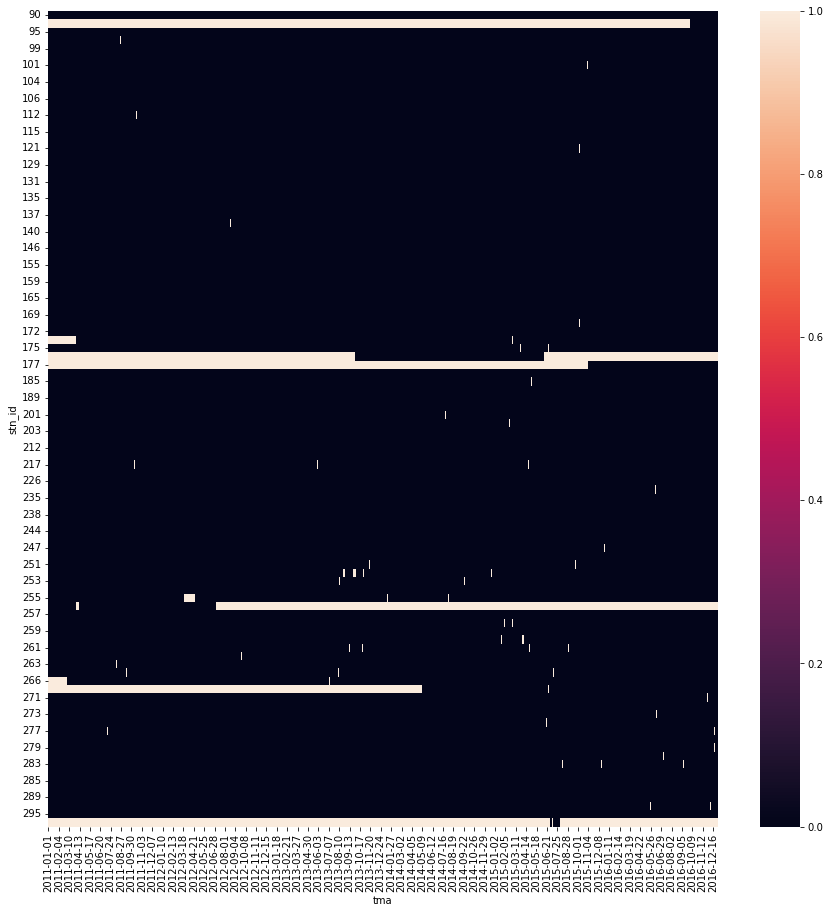

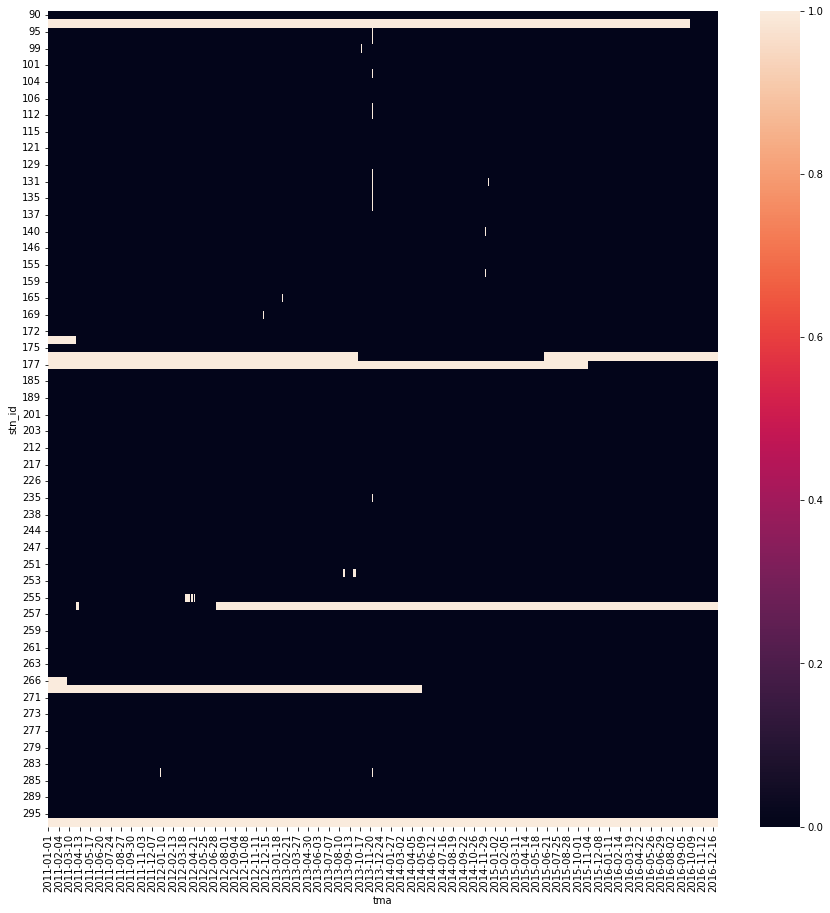

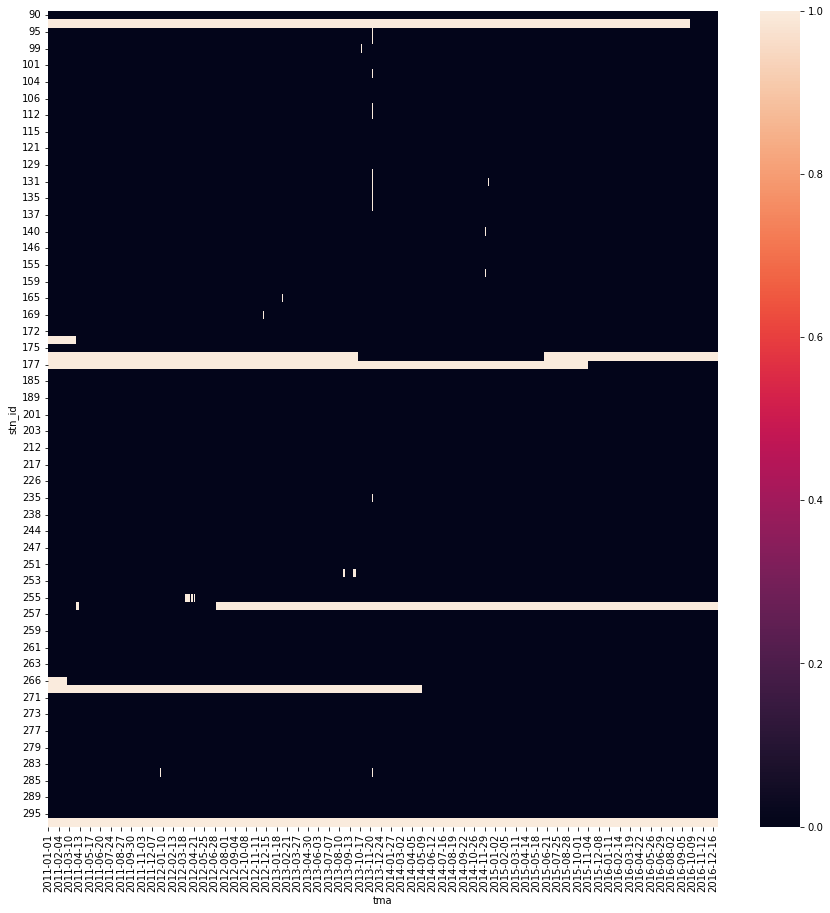

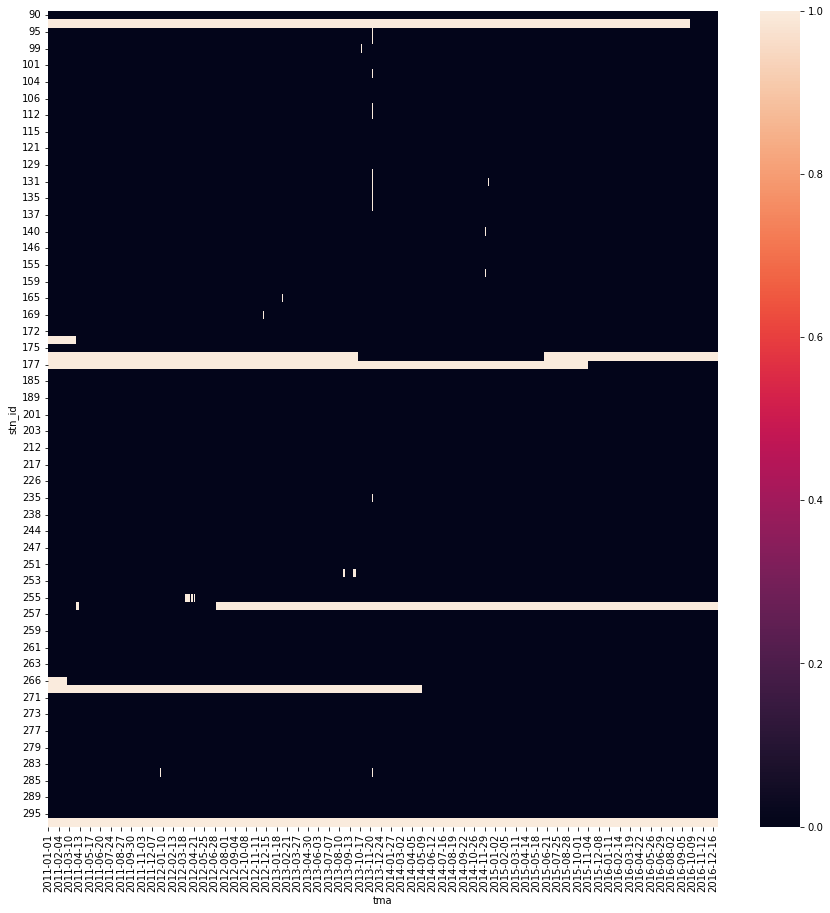

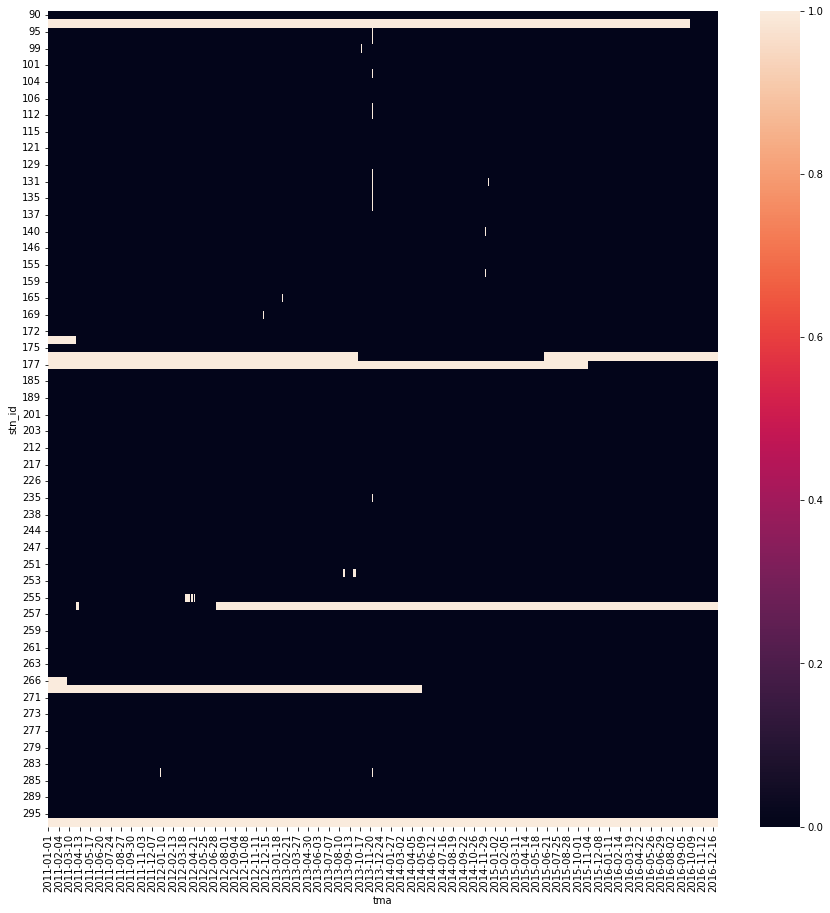

In [18]:
for col in columns:
    plt.figure(figsize = (15, 15))
    sns.heatmap(df.pivot_table(index = "stn_id", columns = "tma", values = col, aggfunc = lambda x: x.isnull().mean()))
    plt.show()

In [29]:
plt.figure(figsize = (15, 15))
drop_idx = pd.DataFrame(df.pivot_table(index = "stn_id", columns = "tma", values = "avg_td", aggfunc = lambda x: x.isnull().mean()).mean(axis = 1), columns = ["null"]).query("null > 0.5").index
df.query("stn_id in @drop_idx")[["stn_id", "add"]].drop_duplicates()

,stn_id,add
135904,256,전남
203856,176,대구
206048,268,전남
208240,864,전북
210432,177,충남
212624,93,강원


<Figure size 1080x1080 with 0 Axes>

In [ ]:
df = df.query("stn_id not in @drop_idx").reset_index(drop = True)
df.to_csv("null_sfc_td.csv", encoding = "utf-8-sig", index = False)

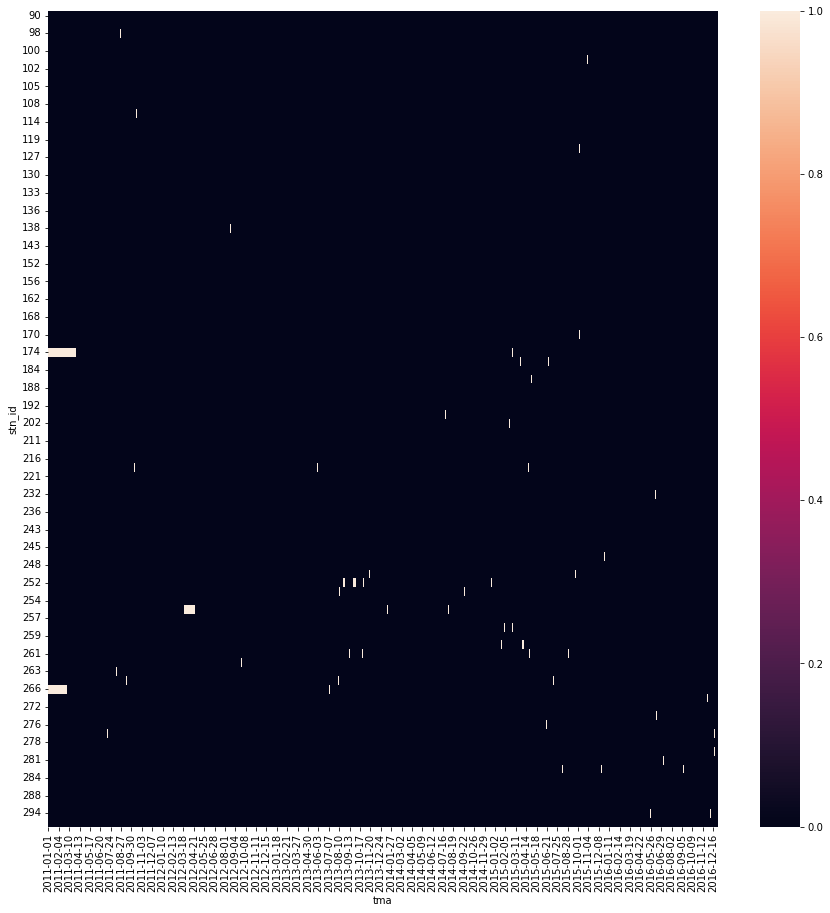

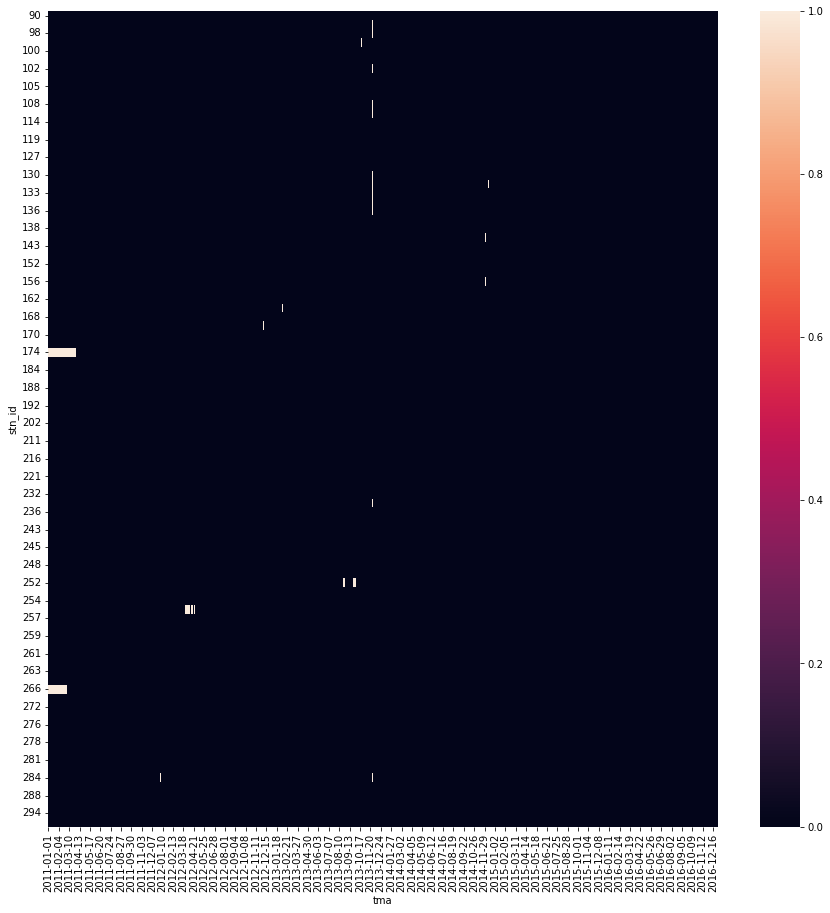

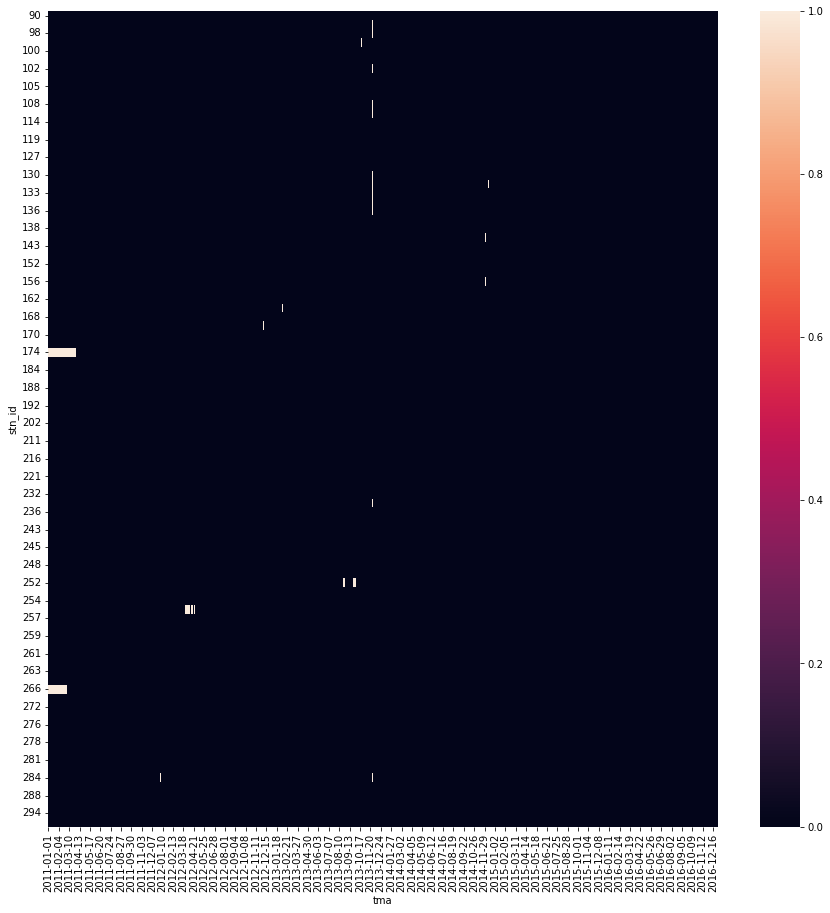

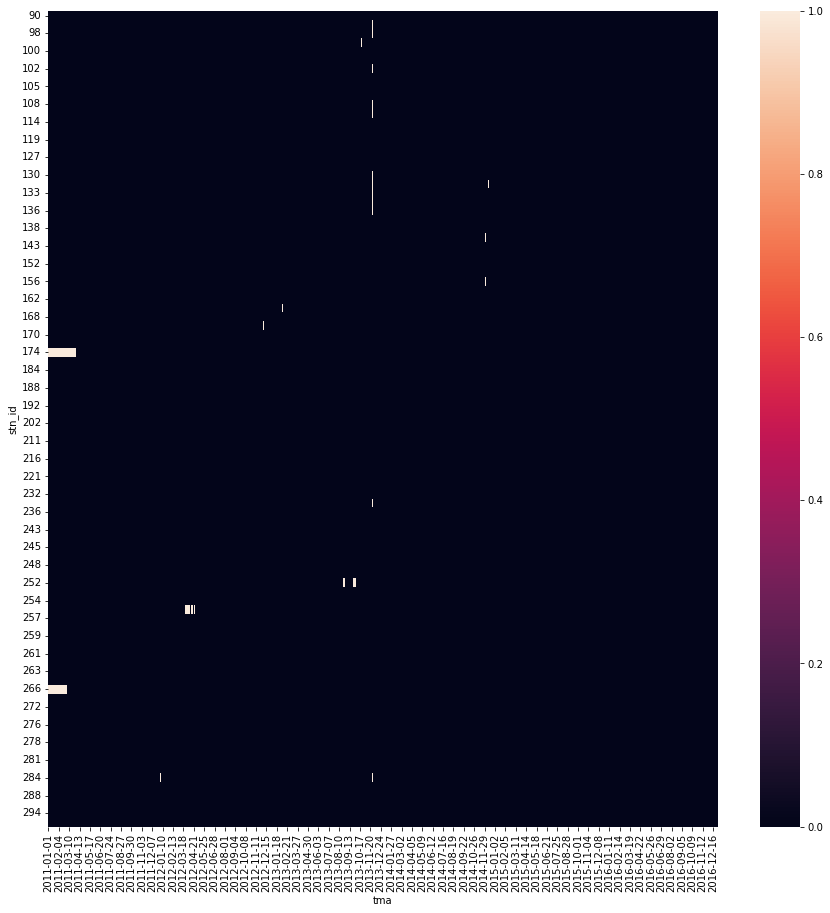

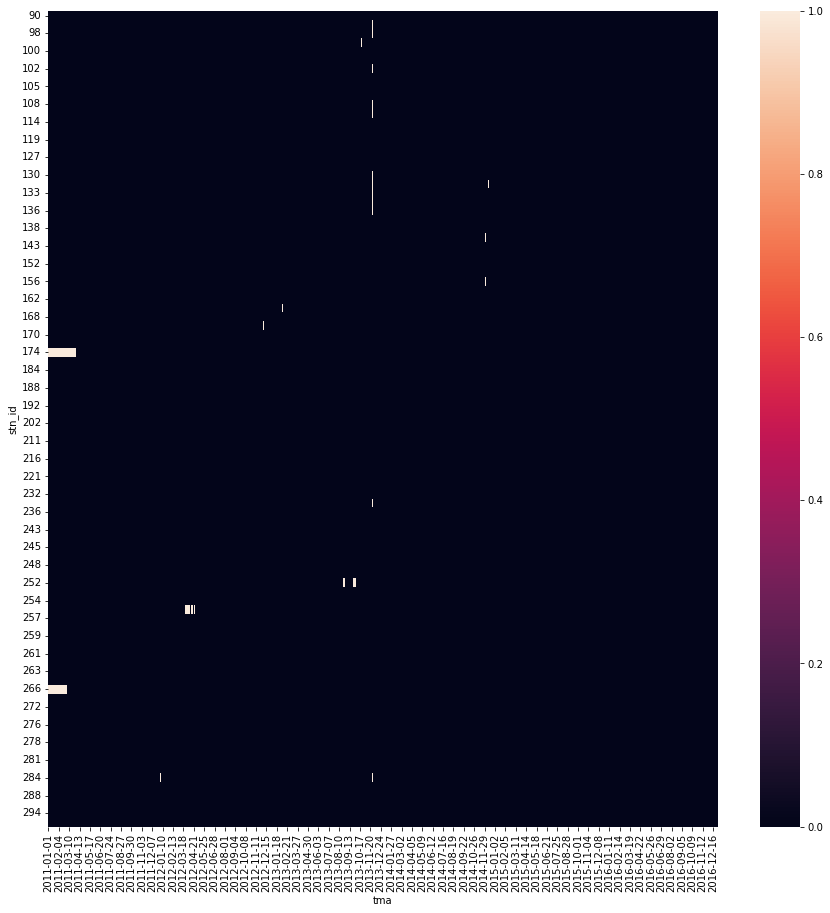

In [20]:
for col in columns:
    plt.figure(figsize = (15, 15))
    sns.heatmap(df.pivot_table(index = "stn_id", columns = "tma", values = col, aggfunc = lambda x: x.isnull().mean()))
    plt.show()

In [55]:
def latlon(area, s):
    latlon = area.query("stn_id == @s")[["lat", "long"]].values[0]
    x = (np.cos(latlon[0]) * 6400 * 2 * np.pi / 360) * np.abs(latlon[1] - area[["long"]])
    y = 111 * np.abs(latlon[0] - area["lat"])
    area["distance"] = np.sqrt((x**2).squeeze() + y**2)
    return area

In [22]:
area3 = df[["stn_id", "address", "lat", "long", "add"]].drop_duplicates().reset_index(drop = True)
print(df.isnull().sum())
for col in columns:
    s_idx = df[df[col].isnull()]["stn_id"].unique()
    for s in s_idx:
        area3 = latlon(area3, s)
        #print(area3.query("distance < 50"))
        df1 = pd.merge(df, area3[["stn_id", "distance"]], on = "stn_id", how = "left")
        df1["index"] = df1.index
        df1 = df1.set_index("distance")
        ymd = df[df[col].isnull()].query("stn_id == @s")["tma"].unique()
        for y in ymd:
            #print(s, y)
            idx = df.query("stn_id == @s and tma == @y").index
            #display(df1.query("tma == @y").interpolate(method = "index").query("distance < 100"))
            df.loc[idx, col] = df1.query("tma == @y").interpolate(method = "index").query("stn_id == @s")[col].values[0]
    print(df.isnull().sum())

yyyymmdd         0
tma              0
stn_id           0
avg_td         373
max_td         236
max_td_hrmt    236
min_td         236
min_td_hrmt    236
name             0
address          0
lat              0
long             0
add              0
dtype: int64
yyyymmdd         0
tma              0
stn_id           0
avg_td           2
max_td         236
max_td_hrmt    236
min_td         236
min_td_hrmt    236
name             0
address          0
lat              0
long             0
add              0
dtype: int64
yyyymmdd         0
tma              0
stn_id           0
avg_td           2
max_td           0
max_td_hrmt    236
min_td         236
min_td_hrmt    236
name             0
address          0
lat              0
long             0
add              0
dtype: int64
yyyymmdd         0
tma              0
stn_id           0
avg_td           2
max_td           0
max_td_hrmt      0
min_td         236
min_td_hrmt    236
name             0
address          0
lat              0
long       

In [23]:
df[df["avg_td"].isnull()]

,yyyymmdd,tma,stn_id,avg_td,max_td,max_td_hrmt,min_td,min_td_hrmt,name,address,lat,long,add
1822,20151228,2015-12-28,90,NaN,-28.1,100.0,-45.0,1700.0,속초,강원도 고성군 토성면 봉포리,38.250875,128.564715,강원
1823,20151229,2015-12-29,90,NaN,-8.7,0.0,-18.9,1800.0,속초,강원도 고성군 토성면 봉포리,38.250875,128.564715,강원


In [24]:
print(df.isnull().sum())
area3 = latlon(area3, 90)
df1 = pd.merge(df, area3[["stn_id", "distance"]], on = "stn_id", how = "left")
df1["index"] = df1.index
df1 = df1.set_index("distance")
ymd = df[df["avg_td"].isnull()].query("stn_id == 90")["tma"].unique()
col = "avg_td"
for y in ymd:
    idx = df.query("stn_id == @s and tma == @y").index
    df.loc[idx, col] = df1.query("tma == @y").interpolate(method = "index").query("stn_id == @s")[col].values[0]
print(df.isnull().sum())

yyyymmdd       0
tma            0
stn_id         0
avg_td         2
max_td         0
max_td_hrmt    0
min_td         0
min_td_hrmt    0
name           0
address        0
lat            0
long           0
add            0
dtype: int64
yyyymmdd       0
tma            0
stn_id         0
avg_td         2
max_td         0
max_td_hrmt    0
min_td         0
min_td_hrmt    0
name           0
address        0
lat            0
long           0
add            0
dtype: int64


In [25]:
df = df.interpolate()
df.isnull().sum()

yyyymmdd       0
tma            0
stn_id         0
avg_td         0
max_td         0
max_td_hrmt    0
min_td         0
min_td_hrmt    0
name           0
address        0
lat            0
long           0
add            0
dtype: int64

In [ ]:
df.to_csv("final_sfc_td_0807_lin.csv", encoding = "utf-8-sig", index = False)